<a href="https://colab.research.google.com/github/a-v-kolos/Allen_dataset_neuromatch_2025/blob/sebastien_bullich/SebTryingStuff_Code_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# ---------------------------------------------------------------
# Mount Google Drive and define output path
# ---------------------------------------------------------------
drive.mount("/content/drive", force_remount=True)
OUTPUT_DIR = "/content/drive/MyDrive/pca_drift_results_test2"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------------------------------------------------------------
# Parameters
# ---------------------------------------------------------------
SESSION_COL   = "ophys_session_id"
EARLY_FRAC    = 0.25
LATE_FRAC     = 0.25
MAX_PC        = 20
INCLUDED_IMAGES = ["im000", "im106", "im075", "im073", "im045", "im054", "im031", "im035", "omitted"]

# Set plot style
sns.set_theme(style="whitegrid", context="talk", font_scale=1.0, palette="colorblind")

# Results container
rows = []

# Extracting data
file_path = "/content/drive/MyDrive/allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet"
data = pd.read_parquet(file_path)
sst_data_2 = data[
    (data.cre_line           == "Sst-IRES-Cre") &
    (data.omitted            == False) &
    (data.exposure_level     == "familiar") &
    (data.targeted_structure == "VISp") &
    (data.session_type       == "OPHYS_3_images_B") &
   # (data.is_change         == "true")
]
print(sst_data_2.shape)
# Loop over all sessions and images
for sess in sst_data_2[SESSION_COL].unique():
    df_sess = sst_data_2[sst_data_2[SESSION_COL] == sess].copy()

    # Create a subfolder for this mouse/session
    #mouse_plot_dir = os.path.join(OUTPUT_DIR, "plots", f"session_{sess}")
    #os.makedirs(mouse_plot_dir, exist_ok=True)

    # Get animal ID for this session (assumes 1 per session)
    mouse_id = df_sess["mouse_id"].iloc[0] if "mouse_id" in df_sess.columns else "unknown"

    # Create subfolder using both mouse and session
    mouse_plot_dir = os.path.join(OUTPUT_DIR, "plots", f"mouse_{mouse_id}_session_{sess}")
    os.makedirs(mouse_plot_dir, exist_ok=True)

    for img in df_sess["image_name"].unique():
        if img not in INCLUDED_IMAGES:
            continue

        df_img = df_sess[df_sess["image_name"] == img].copy()
        if len(df_img) < 2:
            continue

        # Δ response and block labels
        df_img["delta_response"] = df_img["mean_response"] - df_img["baseline_response"]
        df_img = df_img.sort_values("stimulus_presentations_id").reset_index(drop=True)
        N = len(df_img)
        early_cut  = max(1, int(np.floor(EARLY_FRAC * N)))
        late_start = N - max(1, int(np.ceil(LATE_FRAC * N)))
        df_img["block"] = np.where(
            df_img.index < early_cut, "early",
            np.where(df_img.index >= late_start, "late", "middle")
        )

     # Population matrix
        M_df = (
            df_img
            .pivot_table(index="cell_specimen_id",
                        columns="stimulus_presentations_id",
                        values="delta_response",
                        aggfunc="mean")
            .dropna(axis=0, how="all")
            .dropna(axis=1, how="all")
        )

        # Now remove remaining rows/columns with any NaNs (safer than fillna(0.0))
        M_df = M_df.dropna(axis=0, how="any").dropna(axis=1, how="any")

        M = M_df.to_numpy()
        if M.shape[0] < 2 or M.shape[1] < 2:
            continue

        trials = M.shape[1]
        cells = M.shape[0]

        # Block masks
        trial_blocks = (
            df_img[["stimulus_presentations_id", "block"]]
            .drop_duplicates("stimulus_presentations_id")
            .set_index("stimulus_presentations_id")
            .reindex(M_df.columns)["block"]
            .fillna("unknown")
            .to_numpy()
        )
        is_early = trial_blocks == "early"
        is_late  = trial_blocks == "late"

        if not is_early.any() or not is_late.any():
            continue

        # Drift calculation
        v_e = np.mean(M[:, is_early], axis=1)
        v_l = np.mean(M[:, is_late], axis=1)
        if np.isnan(v_e).all() or np.isnan(v_l).all():
            continue

        drift = v_l - v_e
        mag = np.linalg.norm(np.nan_to_num(drift))
        denom = np.linalg.norm(np.nan_to_num(v_e)) * np.linalg.norm(np.nan_to_num(v_l))
        cosang = np.clip((np.nan_to_num(v_e) @ np.nan_to_num(v_l)) / denom if denom else 1, -1, 1)
        angle = np.degrees(np.arccos(cosang))

        rows.append({
            "ophys_session_id": sess,
            "image_name": img,
            "drift_magnitude": mag,
            "drift_angle": angle
        })

        # PCA and plot
        n_comp = min(MAX_PC, trials, cells)
        pca = PCA(n_components=n_comp).fit(M.T)
        scores = pca.transform(M.T)

        if n_comp >= 2:
            fig, ax = plt.subplots(figsize=(5, 5))
            ax.scatter(scores[is_early, 0], scores[is_early, 1],
                       label="early", alpha=0.7, s=40, edgecolor='k')
            ax.scatter(scores[is_late, 0], scores[is_late, 1],
                       label="late", alpha=0.7, s=40, edgecolor='k', marker='^')

            ec = scores[is_early, :2].mean(axis=0)
            lc = scores[is_late, :2].mean(axis=0)
            ax.scatter(*ec, s=100, color='red', marker='o', edgecolor='k')
            ax.scatter(*lc, s=100, color='blue', marker='^', edgecolor='k')
            ax.annotate("", xy=lc, xytext=ec,
                        arrowprops=dict(arrowstyle="->", lw=2, color="gray"))

            ax.set_xlabel("PC1")
            ax.set_ylabel("PC2")
            ax.set_title(f"Session {sess} — Image {img}")
            ax.legend()
            fig.tight_layout()
            fig.savefig(os.path.join(mouse_plot_dir, f"image_{img}.png"))
            plt.close(fig)

# Save drift table
df_out = pd.DataFrame(rows)
df_out.to_csv(os.path.join(OUTPUT_DIR, "drift_metrics_filtered.csv"), index=False)

# Confirm results
print("✅ Done!")
print(f"Saved {len(df_out)} drift metric rows for filtered images")
print("Results saved to:", OUTPUT_DIR)


Mounted at /content/drive
(0, 31)
✅ Done!
Saved 0 drift metric rows for filtered images
Results saved to: /content/drive/MyDrive/pca_drift_results_test2


In [71]:
#print(sst_data_2.head())
#print(M_df.head())
print(M_df.shape)

(4, 18)


In [67]:
# === 1. Upload CSV ===
from google.colab import files
import pandas as pd
import io

uploaded = files.upload()
filename = list(uploaded.keys())[0]
df_out = pd.read_csv(io.BytesIO(uploaded[filename]))

# === 2. Summary statistics ===
summary_df = df_out.groupby("image_name").agg(
    drift_magnitude_mean=("drift_magnitude", "mean"),
    drift_magnitude_sem=("drift_magnitude", "sem"),
    drift_angle_mean=("drift_angle", "mean"),
    drift_angle_sem=("drift_angle", "sem")
).reset_index()

plot_order = sorted(summary_df["image_name"].unique().tolist())

# === 3. Significance annotation ===
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from itertools import combinations
import numpy as np

def add_significance(df, value_col, group_col, ax, order, spacing_fraction=0.05):
    pairs = list(combinations(order, 2))
    y_max = df[value_col].max()
    y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
    n_lines = 0

    for g1, g2 in pairs:
        data1 = df[df[group_col] == g1][value_col]
        data2 = df[df[group_col] == g2][value_col]
        stat, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')

        print(f"{g1} vs {g2}: p = {p:.4f}")
        if p < 0.05:
            x1 = order.index(g1)
            x2 = order.index(g2)
            x_coords = [x1, x1, x2, x2]
            y = y_max + (n_lines + 1) * spacing_fraction * y_range
            y_coords = [y, y + 0.01 * y_range, y + 0.01 * y_range, y]
            ax.plot(x_coords, y_coords, lw=1.5, color='black')
            ax.text((x1 + x2) / 2, y + 0.015 * y_range, '*', ha='center', va='bottom', color='black', fontsize=14)
            n_lines += 1

    ax.set_ylim(top=y_max + (n_lines + 2) * spacing_fraction * y_range)

# === 4. Rainbow color palette
palette = sns.color_palette("hsv", len(plot_order))

# === 5. Plotting function
def plot_with_points(df_summary, df_raw, mean_col, sem_col, raw_col, title, ylabel):
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df_summary, x="image_name", y=mean_col,
        errorbar=None, order=plot_order, palette=palette
    )
    plt.title(title, fontsize=16)
    plt.xlabel("Image Name", fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    # Add error bars
    for i, img in enumerate(plot_order):
        row = df_summary[df_summary["image_name"] == img].iloc[0]
        ax.errorbar(i, row[mean_col], yerr=row[sem_col], fmt='none', capsize=5, color='black')

    # Add individual points (transparent)
    for i, img in enumerate(plot_order):
        y_vals = df_raw[df_raw["image_name"] == img][raw_col].values
        x_vals = np.random.normal(loc=i, scale=0.08, size=len(y_vals))
        ax.scatter(x_vals, y_vals, alpha=0.4, color=palette[i], edgecolor='k', linewidth=0.3)

    # Add significance stars
    add_significance(df_raw, raw_col, "image_name", ax, order=plot_order)

    plt.tight_layout()
    plt.show()

# === 6. Final plots ===
plot_with_points(summary_df, df_out, "drift_magnitude_mean", "drift_magnitude_sem", "drift_magnitude",
                 "Average Drift Magnitude by Image", "Drift Magnitude")

plot_with_points(summary_df, df_out, "drift_angle_mean", "drift_angle_sem", "drift_angle",
                 "Average Drift Angle by Image", "Drift Angle (degrees)")


KeyboardInterrupt: 

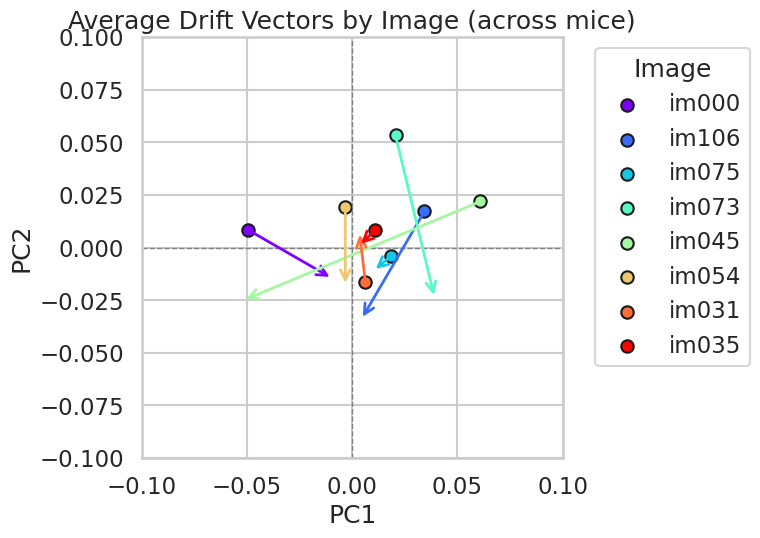

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from collections import defaultdict

# Define color map
colors = plt.cm.rainbow(np.linspace(0, 1, len(INCLUDED_IMAGES)))
image_color_map = dict(zip(INCLUDED_IMAGES, colors))

# Containers for early and late centroids per image per mouse
centroid_data = defaultdict(list)  # key = image_name, value = list of (early, late) centroid tuples

for mouse in sst_data_2["mouse_id"].unique():
    df_mouse = sst_data_2[sst_data_2["mouse_id"] == mouse]

    for img in df_mouse["image_name"].unique():
        if img not in INCLUDED_IMAGES:
            continue

        df_img = df_mouse[df_mouse["image_name"] == img].copy()
        if len(df_img) < 2:
            continue

        df_img["delta_response"] = df_img["mean_response"] - df_img["baseline_response"]
        df_img = df_img.sort_values("stimulus_presentations_id").reset_index(drop=True)
        N = len(df_img)
        early_cut  = max(1, int(np.floor(EARLY_FRAC * N)))
        late_start = N - max(1, int(np.ceil(LATE_FRAC * N)))
        df_img["block"] = np.where(
            df_img.index < early_cut, "early",
            np.where(df_img.index >= late_start, "late", "middle")
        )

        M_df = (
            df_img
            .pivot_table(index="cell_specimen_id",
                         columns="stimulus_presentations_id",
                         values="delta_response",
                         aggfunc="mean")
            .dropna(axis=0, how="any")
            .dropna(axis=1, how="any")
        )

        M = M_df.to_numpy()
        if M.shape[0] < 2 or M.shape[1] < 2:
            continue

        trial_blocks = (
            df_img[["stimulus_presentations_id", "block"]]
            .drop_duplicates("stimulus_presentations_id")
            .set_index("stimulus_presentations_id")
            .reindex(M_df.columns)["block"]
            .fillna("unknown")
            .to_numpy()
        )
        is_early = trial_blocks == "early"
        is_late  = trial_blocks == "late"

        if not is_early.any() or not is_late.any():
            continue

        n_comp = min(MAX_PC, M.shape[0], M.shape[1])
        pca = PCA(n_components=n_comp).fit(M.T)
        scores = pca.transform(M.T)

        if n_comp >= 2:
            ec = scores[is_early, :2].mean(axis=0)
            lc = scores[is_late, :2].mean(axis=0)
            centroid_data[img].append((ec, lc))

# Compute average centroids and plot arrows
plt.figure(figsize=(8, 8))
ax = plt.gca()

for img_idx, img in enumerate(INCLUDED_IMAGES):
    if img not in centroid_data:
        continue

    all_ec = np.array([pair[0] for pair in centroid_data[img]])
    all_lc = np.array([pair[1] for pair in centroid_data[img]])

    mean_ec = all_ec.mean(axis=0)
    mean_lc = all_lc.mean(axis=0)

    # Arrow
    ax.annotate("",
                xy=mean_lc, xytext=mean_ec,
                arrowprops=dict(arrowstyle="->", lw=2, color=image_color_map[img]))
    ax.scatter(*mean_ec, color=image_color_map[img], edgecolor='k', s=80, label=img)

# Axis formatting
ax.axhline(0, color="gray", linestyle="--", linewidth=1)
ax.axvline(0, color="gray", linestyle="--", linewidth=1)
ax.set_xlim(-0.1, 0.1)
ax.set_ylim(-0.1, 0.1)
ax.set_title("Average Drift Vectors by Image (across mice)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_aspect("equal")
ax.legend(title="Image", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()



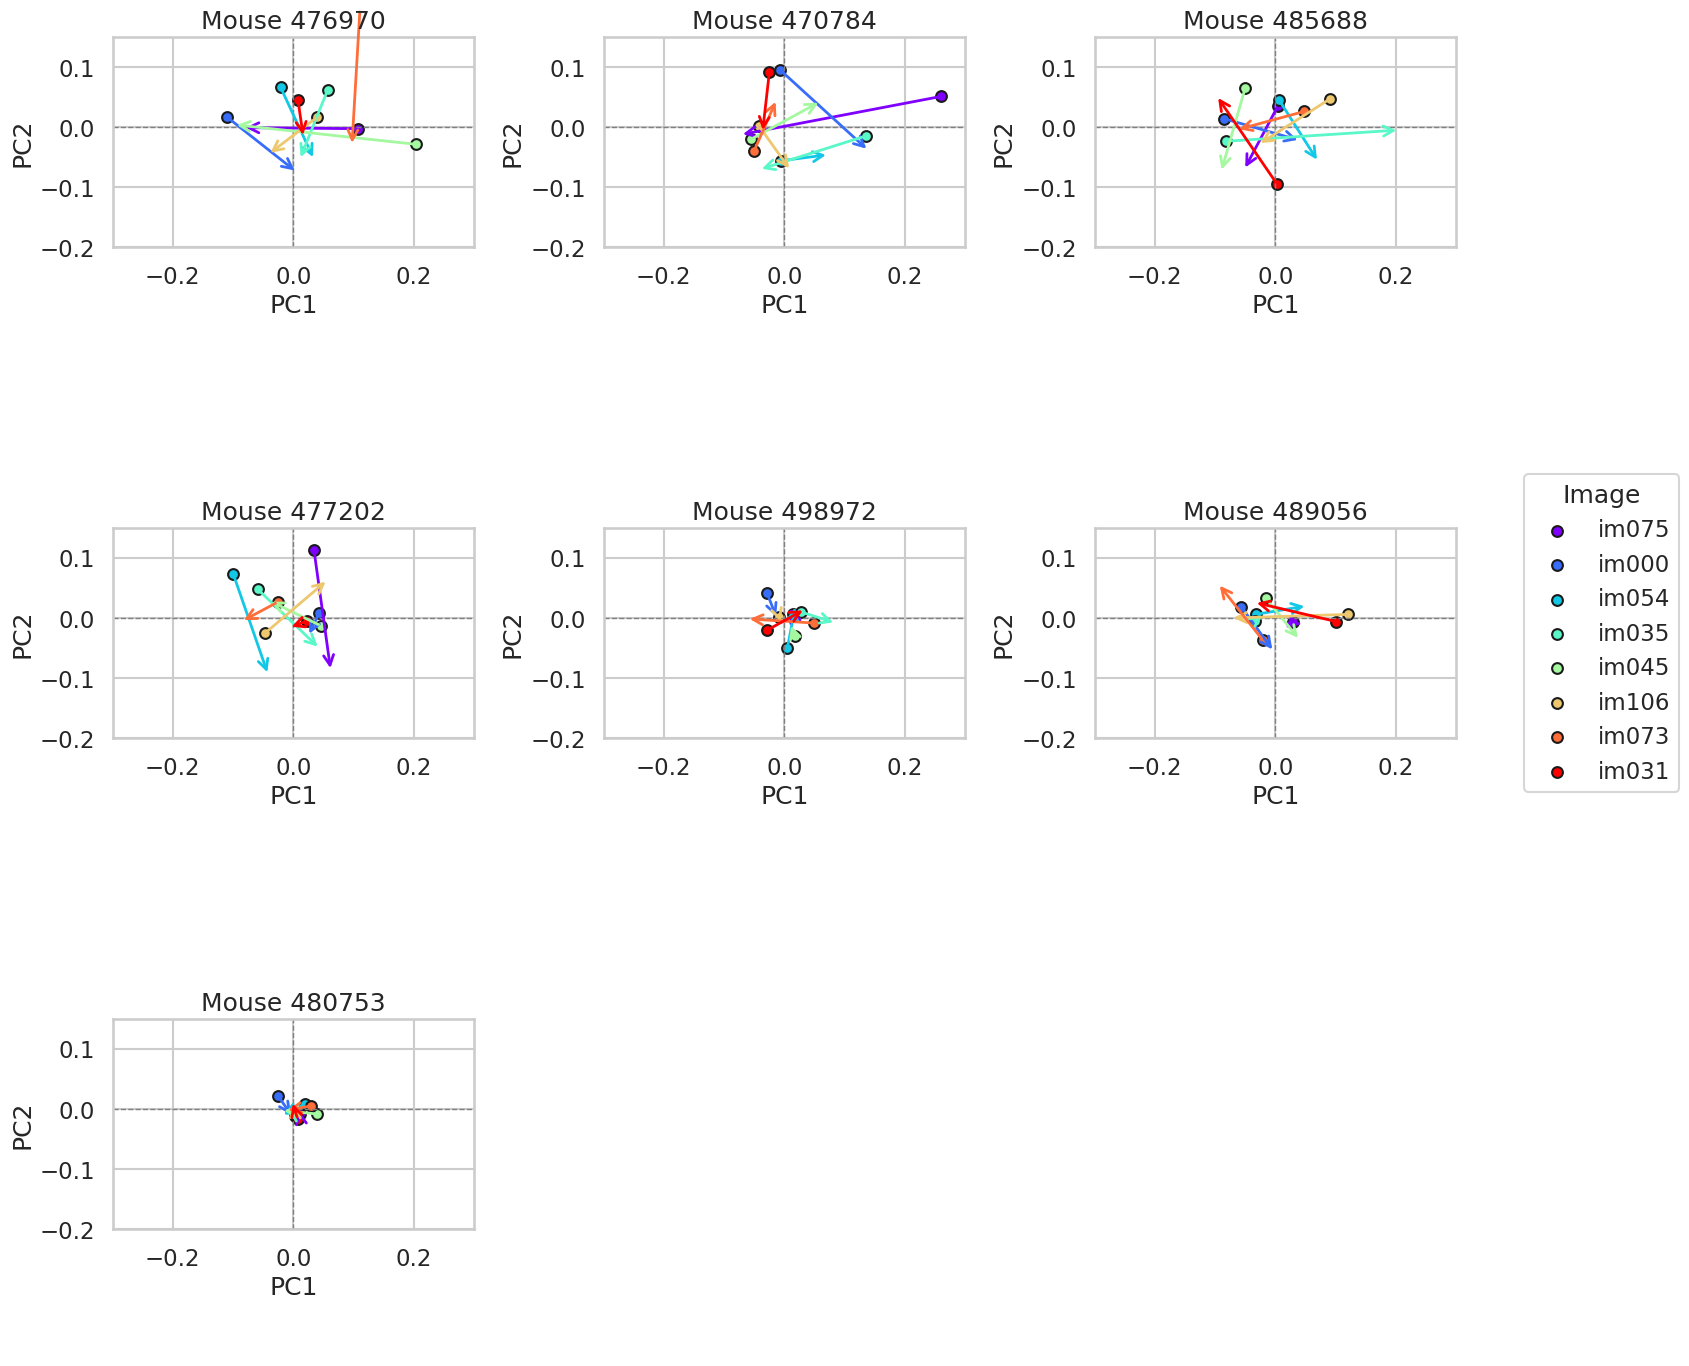

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from matplotlib.cm import get_cmap

# Prepare
mice = sst_data_2["mouse_id"].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(INCLUDED_IMAGES)))
n_mice = len(mice)
ncols = 3
nrows = int(np.ceil(n_mice / ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
axs = axs.flatten()

for idx, mouse in enumerate(mice):
    ax = axs[idx]
    df_mouse = sst_data_2[sst_data_2["mouse_id"] == mouse]

    for img_idx, img in enumerate(df_mouse["image_name"].unique()):
        if img not in INCLUDED_IMAGES:
            continue

        df_img = df_mouse[df_mouse["image_name"] == img].copy()
        if len(df_img) < 2:
            continue

        df_img["delta_response"] = df_img["mean_response"] - df_img["baseline_response"]
        df_img = df_img.sort_values("stimulus_presentations_id").reset_index(drop=True)
        N = len(df_img)
        early_cut  = max(1, int(np.floor(EARLY_FRAC * N)))
        late_start = N - max(1, int(np.ceil(LATE_FRAC * N)))
        df_img["block"] = np.where(
            df_img.index < early_cut, "early",
            np.where(df_img.index >= late_start, "late", "middle")
        )

        M_df = (
            df_img
            .pivot_table(index="cell_specimen_id",
                         columns="stimulus_presentations_id",
                         values="delta_response",
                         aggfunc="mean")
            .dropna(axis=0, how="any")
            .dropna(axis=1, how="any")
        )

        M = M_df.to_numpy()
        if M.shape[0] < 2 or M.shape[1] < 2:
            continue

        trial_blocks = (
            df_img[["stimulus_presentations_id", "block"]]
            .drop_duplicates("stimulus_presentations_id")
            .set_index("stimulus_presentations_id")
            .reindex(M_df.columns)["block"]
            .fillna("unknown")
            .to_numpy()
        )
        is_early = trial_blocks == "early"
        is_late  = trial_blocks == "late"

        if not is_early.any() or not is_late.any():
            continue

        n_comp = min(MAX_PC, M.shape[0], M.shape[1])
        pca = PCA(n_components=n_comp).fit(M.T)
        scores = pca.transform(M.T)

        if n_comp >= 2:
            ec = scores[is_early, :2].mean(axis=0)
            lc = scores[is_late, :2].mean(axis=0)

            ax.annotate("",
                        xy=lc, xytext=ec,
                        arrowprops=dict(arrowstyle="->", lw=2, color=colors[img_idx]))
            ax.scatter(*ec, color=colors[img_idx], edgecolor='k', s=60, label=img)

    ax.set_title(f"Mouse {mouse}")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.axhline(0, color="gray", linestyle="--", linewidth=1)
    ax.axvline(0, color="gray", linestyle="--", linewidth=1)
    ax.set_aspect("equal")
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-0.2, 0.15)

# Hide any unused subplots
for i in range(n_mice, len(axs)):
    axs[i].axis("off")

# Global legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Image", bbox_to_anchor=(1.02, 0.5), loc="center left")

plt.tight_layout()
plt.show()


In [4]:
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from google.colab import drive

# ---------------------------------------------------------------
# Mount Google Drive and define output path
# ---------------------------------------------------------------
drive.mount("/content/drive", force_remount=True)
OUTPUT_DIR = "/content/drive/MyDrive/pca_drift_results_Euclidiandistance"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------------------------------------------------------------
# Parameters
# ---------------------------------------------------------------
SESSION_COL   = "ophys_session_id"
EARLY_FRAC    = 0.25
LATE_FRAC     = 0.25
MAX_PC        = 20
INCLUDED_IMAGES = ["im000", "im106", "im075", "im073", "im045", "im054", "im031", "im035"]

# Set plot style
sns.set_theme(style="whitegrid", context="talk", font_scale=1.0, palette="colorblind")

# Results container
rows = []

# Extracting data
file_path = "/content/drive/MyDrive/allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet"
data = pd.read_parquet(file_path)
sst_data_2 = data[
    (data.cre_line           == "Sst-IRES-Cre") &
    (data.omitted            == False) &
    (data.exposure_level     == "familiar") &
    (data.targeted_structure == "VISp") &
    (data.session_type       == "OPHYS_3_images_B")
]
print("Filtered data shape:", sst_data_2.shape)

# Loop over all sessions
for sess in sst_data_2[SESSION_COL].unique():
    df_sess = sst_data_2[sst_data_2[SESSION_COL] == sess].copy()

    mouse_id = df_sess["mouse_id"].iloc[0] if "mouse_id" in df_sess.columns else "unknown"
    mouse_plot_dir = os.path.join(OUTPUT_DIR, "plots", f"mouse_{mouse_id}_session_{sess}")
    os.makedirs(mouse_plot_dir, exist_ok=True)

    session_M_df_list = []
    session_scores_list = []
    session_trial_info_list = []

    for img in df_sess["image_name"].unique():
        if img not in INCLUDED_IMAGES:
            continue

        df_img = df_sess[df_sess["image_name"] == img].copy()
        if len(df_img) < 2:
            continue

        df_img["delta_response"] = df_img["mean_response"] - df_img["baseline_response"]
        df_img = df_img.sort_values("stimulus_presentations_id").reset_index(drop=True)
        N = len(df_img)
        early_cut  = max(1, int(np.floor(EARLY_FRAC * N)))
        late_start = N - max(1, int(np.ceil(LATE_FRAC * N)))
        df_img["block"] = np.where(
            df_img.index < early_cut, "early",
            np.where(df_img.index >= late_start, "late", "middle")
        )

        M_df = (
            df_img
            .pivot_table(index="cell_specimen_id",
                         columns="stimulus_presentations_id",
                         values="delta_response",
                         aggfunc="mean")
            .dropna(axis=0, how="all")
            .dropna(axis=1, how="all")
        ).dropna(axis=0, how="any").dropna(axis=1, how="any")

        M = M_df.to_numpy()
        if M.shape[0] < 2 or M.shape[1] < 2:
            continue

        trial_blocks = (
            df_img[["stimulus_presentations_id", "block"]]
            .drop_duplicates("stimulus_presentations_id")
            .set_index("stimulus_presentations_id")
            .reindex(M_df.columns)["block"]
            .fillna("unknown")
            .to_numpy()
        )
        is_early = trial_blocks == "early"
        is_late  = trial_blocks == "late"
        if not is_early.any() or not is_late.any():
            continue

        v_e = np.mean(M[:, is_early], axis=1)
        v_l = np.mean(M[:, is_late], axis=1)
        if np.isnan(v_e).all() or np.isnan(v_l).all():
            continue

        drift = v_l - v_e
        mag = np.linalg.norm(np.nan_to_num(drift))
        denom = np.linalg.norm(np.nan_to_num(v_e)) * np.linalg.norm(np.nan_to_num(v_l))
        cosang = np.clip((np.nan_to_num(v_e) @ np.nan_to_num(v_l)) / denom if denom else 1, -1, 1)
        angle = np.degrees(np.arccos(cosang))

        # PCA
        n_comp = min(MAX_PC, M.shape[1], M.shape[0])
        pca = PCA(n_components=n_comp).fit(M.T)
        scores = pca.transform(M.T)

        # Radius in PC1–PC2 space
        r2 = np.sqrt(scores[:, 0]**2 + scores[:, 1]**2)
        r2_early = r2[is_early]
        r2_late  = r2[is_late]
        rad_early_mean = np.nanmean(r2_early) if r2_early.size else np.nan
        rad_late_mean  = np.nanmean(r2_late)  if r2_late.size  else np.nan
        rad_early_median = np.nanmedian(r2_early) if r2_early.size else np.nan
        rad_late_median  = np.nanmedian(r2_late)  if r2_late.size  else np.nan

        # Save results
        rows.append({
            "mouse_id": mouse_id,
            "ophys_session_id": sess,
            "image_name": img,
            "drift_magnitude": mag,
            "drift_angle": angle,
            "pc2_radius_early_mean": rad_early_mean,
            "pc2_radius_late_mean": rad_late_mean,
            "pc2_radius_early_median": rad_early_median,
            "pc2_radius_late_median": rad_late_median,
            "n_early_trials": int(is_early.sum()),
            "n_late_trials": int(is_late.sum())
        })

        # Save for multi-image PCA plot
        session_M_df_list.append(M_df)
        session_scores_list.append(scores)
        trial_info_df = (
            df_img[["stimulus_presentations_id", "image_name", "block"]]
            .drop_duplicates("stimulus_presentations_id")
            .set_index("stimulus_presentations_id")
            .reindex(M_df.columns)
        )
        session_trial_info_list.append(trial_info_df)

        # Per-image PCA plot
        if n_comp >= 2:
            fig, ax = plt.subplots(figsize=(5, 5))
            ax.scatter(scores[is_early, 0], scores[is_early, 1],
                       label="early", alpha=0.7, s=40, edgecolor='k')
            ax.scatter(scores[is_late, 0], scores[is_late, 1],
                       label="late", alpha=0.7, s=40, edgecolor='k', marker='^')

            ec = scores[is_early, :2].mean(axis=0)
            lc = scores[is_late, :2].mean(axis=0)
            ax.scatter(*ec, s=100, color='red', marker='o', edgecolor='k')
            ax.scatter(*lc, s=100, color='blue', marker='^', edgecolor='k')
            ax.annotate("", xy=lc, xytext=ec,
                        arrowprops=dict(arrowstyle="->", lw=2, color="gray"))

            ax.set_xlabel("PC1")
            ax.set_ylabel("PC2")
            ax.set_title(f"Session {sess} — Image {img}")
            ax.legend()
            fig.tight_layout()
            fig.savefig(os.path.join(mouse_plot_dir, f"image_{img}.png"))
            plt.close(fig)

    # Multi-image PCA plot
    if session_scores_list and session_trial_info_list:
        all_scores = np.concatenate(session_scores_list, axis=0)
        all_trial_info = pd.concat(session_trial_info_list)
        trial_image_map = all_trial_info["image_name"].fillna("unknown").to_numpy()
        trial_block_map = all_trial_info["block"].fillna("unknown").to_numpy()

        unique_images = np.unique(trial_image_map)
        cmap = cm.get_cmap("tab10", len(unique_images))
        image_to_color = {img: cmap(i) for i, img in enumerate(unique_images)}

        fig, ax = plt.subplots(figsize=(8, 6))
        for img in unique_images:
            is_img = (trial_image_map == img)
            is_img_early = is_img & (trial_block_map == "early")
            is_img_late  = is_img & (trial_block_map == "late")

            if np.any(is_img_early):
                early_centroid = all_scores[is_img_early, :2].mean(axis=0)
                ax.scatter(*early_centroid, marker='o', s=150,
                           edgecolor='k', color=image_to_color[img], label=f"{img} early")
            if np.any(is_img_late):
                late_centroid = all_scores[is_img_late, :2].mean(axis=0)
                ax.scatter(*late_centroid, marker='^', s=150,
                           edgecolor='k', color=image_to_color[img], label=f"{img} late")
            if np.any(is_img_early) and np.any(is_img_late):
                ax.annotate("",
                    xy=late_centroid, xytext=early_centroid,
                    arrowprops=dict(arrowstyle="->", lw=2, color=image_to_color[img])
                )

        ax.set_xlabel("PC1 score")
        ax.set_ylabel("PC2 score")
        ax.set_title(f"PCA: Early→Late centroids per image\nMouse {mouse_id} — Session {sess}")
        ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")
        sns.despine(trim=True)
        fig.tight_layout()
        fig.savefig(os.path.join(mouse_plot_dir, "multi_image_centroids.png"))
        plt.close(fig)

# Save drift table
df_out = pd.DataFrame(rows)
df_out.to_csv(os.path.join(OUTPUT_DIR, "drift_metrics_filtered.csv"), index=False)

# Final summary plot: early vs. late radius
plt.figure(figsize=(6,6))
plt.scatter(df_out["pc2_radius_early_mean"], df_out["pc2_radius_late_mean"],
            edgecolor='k', alpha=0.6)
lim = max(df_out[["pc2_radius_early_mean", "pc2_radius_late_mean"]].max())
plt.plot([0, lim], [0, lim], ls='--', color='gray')
plt.xlabel("Early radius (PC1–PC2)")
plt.ylabel("Late radius (PC1–PC2)")
plt.title("PC1–PC2 Radius: Early vs Late")
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "radius_scatter.png"))
plt.show()

# Confirm results
print("✅ Done!")
print(f"Saved {len(df_out)} drift metric rows for filtered images")
print("Results saved to:", OUTPUT_DIR)


KeyboardInterrupt: 